In [5]:
import warnings
warnings.filterwarnings('ignore')

from src.prepare import telco_model_prep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

import eli5

## Predicting Telco Churn

[Preprocessing](#preprocessing)

[Modeling](#modeling)

In [34]:
df = telco_model_prep()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   tenure             7043 non-null   int64  
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   partner            7043 non-null   uint8  
 6   dependents         7043 non-null   uint8  
 7   multiple_lines     7043 non-null   uint8  
 8   dsl                7043 non-null   uint8  
 9   fiber_optic        7043 non-null   uint8  
 10  online_security    7043 non-null   uint8  
 11  online_backup      7043 non-null   uint8  
 12  device_protection  7043 non-null   uint8  
 13  tech_support       7043 non-null   uint8  
 14  streaming_tv       7043 non-null   uint8  
 15  streaming_movies   7043 non-null   uint8  
 16  one_month          7043 

In [35]:
df.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,partner,dependents,multiple_lines,dsl,fiber_optic,...,tech_support,streaming_tv,streaming_movies,one_month,one_year,paperless,e_check,check,bank_transfer,churn
0,0002-ORFBO,0,9,65.6,593.30,1,1,0,1,0,...,1,1,0,0,1,1,0,1,0,0
1,0003-MKNFE,0,9,59.9,542.40,0,0,1,1,0,...,0,0,1,1,0,0,0,1,0,0
2,0004-TLHLJ,0,4,73.9,280.85,0,0,0,0,1,...,0,0,0,1,0,1,1,0,0,1
3,0011-IGKFF,1,13,98.0,1237.85,1,0,0,0,1,...,0,1,1,1,0,1,1,0,0,1
4,0013-EXCHZ,1,3,83.9,267.40,1,0,0,0,1,...,1,1,0,1,0,1,0,1,0,1


<a id='preprocessing'></a>
## Preprocessing

In [36]:
churn = df.pop("churn")

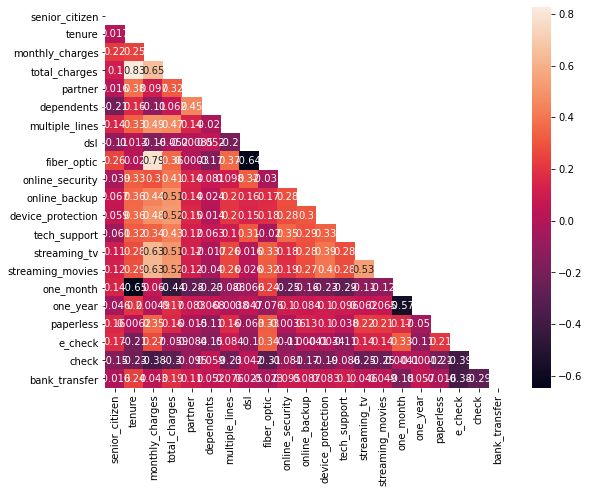

In [37]:
plt.figure(figsize=(9,7))
corr = df.corr()
sns.heatmap(corr, mask=np.triu(corr), annot=True);

Multicollinearity can be detected via various methods. The most common one – VIF (Variable Inflation Factors).

    ” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. “

    or

    VIF score of an independent variable represents how well the variable is explained by other independent variables.

* VIF starts at 1 and has no upper limit
* VIF = 1, no correlation between the independent variable and the other variables
* VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others


In [38]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [round(variance_inflation_factor(X.values, i),1) for i in range(X.shape[1])]
    return(vif)

In [39]:
calc_vif(df.iloc[:,1:])

,variables,VIF
0,senior_citizen,1.4
1,tenure,12.3
2,monthly_charges,115.0
3,total_charges,17.5
4,partner,2.8
5,dependents,2.0
6,multiple_lines,3.1
7,dsl,8.8
8,fiber_optic,35.8
9,online_security,2.3


In [41]:
#df['streaming'] =  (df.streaming_movies + df.streaming_tv > 0).astype(int)
df = df.drop(['monthly_charges', 'total_charges'], axis=1)

In [42]:
calc_vif(df.iloc[:,1:])

,variables,VIF
0,senior_citizen,1.4
1,tenure,4.7
2,partner,2.8
3,dependents,1.9
4,multiple_lines,2.3
5,dsl,4.8
6,fiber_optic,7.2
7,online_security,2.0
8,online_backup,2.1
9,device_protection,2.3


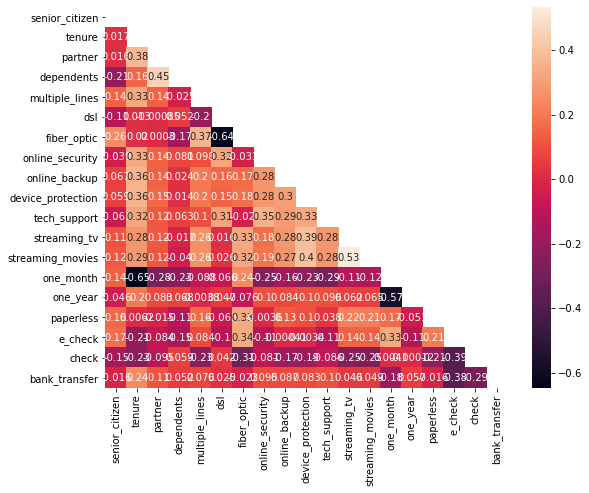

In [43]:
plt.figure(figsize=(9,7))
corr = df.corr()
sns.heatmap(corr, mask=np.triu(corr), annot=True);

### Oversampling & Train-Val-Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df, churn, test_size=.1,
                                                    random_state=36, stratify=churn)
X_train.pop("customer_id")
cid = X_test.pop("customer_id") #needed for output file
#make val before oversampling so test and val come from the same distribution
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9,
                                                    random_state=36, stratify=y_train)

In [46]:
#synthetic training data made with kNN algorithm
X_smote, y_smote = SMOTE(random_state=36).fit_resample(X_train, y_train)
y_smote.value_counts() #oversampling the churn class

0    4138
1    4138
Name: churn, dtype: int64

In [47]:
X_train.shape, X_test.shape, X_val.shape, X_smote.shape, y_test.shape, y_train.shape, y_val.shape, y_smote.shape,

((5633, 19),
 (705, 19),
 (705, 19),
 (8276, 19),
 (705,),
 (5633,),
 (705,),
 (8276,))

<a id='modeling'></a>
## Modeling

In [48]:
#baseline: no churn
#tp / (tp + fp) is precision & tp / (tp + fn) is recall
print(f"Accuracy: {np.round(1 - sum(y_test)/len(y_test), 2)}")
print(classification_report(y_test, np.zeros(len(y_test))))

Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       518
           1       0.00      0.00      0.00       187

    accuracy                           0.73       705
   macro avg       0.37      0.50      0.42       705
weighted avg       0.54      0.73      0.62       705



Why not predict all zeros?

Low recall is a big problem. Accuracy is a distraction with imbalanced classes. The model isn't picking up on why customers leave, which is the whole point of the analysis.

Imagine churn jumps from 74% to 90%. The dumb model will be doing excellent and the business will be insolvent.

Why not predict all ones?

Karl Popper — 'A theory that explains everything, explains nothing'

THis model is the boy who cried wolf. You have to focus resources on something, or else you will accomplish nothing. Giving equal attention to the 3/4 of satisifed customers will not address the high-value, high-risk customers leaving every month.

### Non-linear classifiers

### kNN

In [51]:
scores_in, scores_out = [], []
k_values = range(1,31)

for k in k_values:
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_smote, y_smote)
    scores_in.append(knn.score(X_train, y_train))
    scores_out.append(knn.score(X_val, y_val))                 

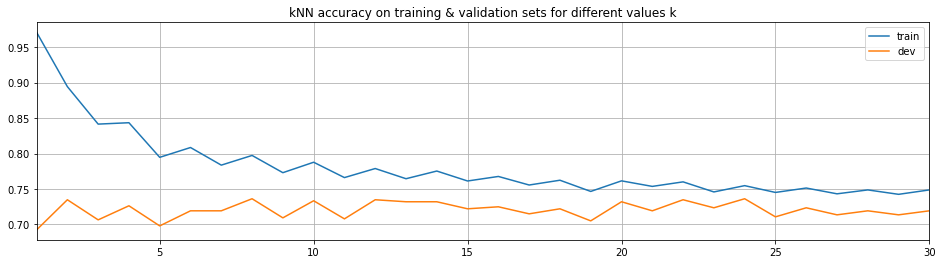

In [52]:
f = plt.subplots(figsize=(16,4))
plt.plot(k_values, scores_in)
plt.plot(k_values, scores_out)
plt.grid()
plt.xlim(1,30)
plt.legend(["train","dev"])
plt.title("kNN accuracy on training & validation sets for different values k");

In [54]:
k=20
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
knn.fit(X_train, y_train)
print(classification_report(y_val, knn.predict(X_val)))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       518
           1       0.63      0.54      0.58       187

    accuracy                           0.79       705
   macro avg       0.73      0.71      0.72       705
weighted avg       0.78      0.79      0.79       705



In [55]:
#SMOTE data increases correct churn predictions and non-churn errors equally, I prefer this model over the one above but accuracy is too low
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
knn.fit(X_smote, y_smote)
print(classification_report(y_val, knn.predict(X_val)))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80       518
           1       0.50      0.74      0.60       187

    accuracy                           0.73       705
   macro avg       0.69      0.74      0.70       705
weighted avg       0.78      0.73      0.75       705



### tree

In [56]:
#ccp_alpha prunes weak links based on impurity, a useless, 100% impure node splits evenly (50/50) whereas a 100% pure node classifies all samples to one class
dt = DecisionTreeClassifier(ccp_alpha=.001, random_state=36)
dt.fit(X_train, y_train)
print(classification_report(y_val, dt.predict(X_val)))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       518
           1       0.61      0.68      0.64       187

    accuracy                           0.80       705
   macro avg       0.74      0.76      0.75       705
weighted avg       0.81      0.80      0.80       705



In [57]:
dt = DecisionTreeClassifier(ccp_alpha=.001, random_state=36)
dt.fit(X_smote, y_smote)
print(classification_report(y_val, dt.predict(X_val)))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       518
           1       0.51      0.75      0.61       187

    accuracy                           0.74       705
   macro avg       0.70      0.75      0.71       705
weighted avg       0.79      0.74      0.76       705



In [ ]:
eli5.show_weights(dt, top=5, feature_names=list(X_train.columns))

In [ ]:
plt.figure(figsize=(21,9))
plot_tree(dt, feature_names=X_val.columns, class_names=True);

### forest

In [58]:
rf = RandomForestClassifier(ccp_alpha=.005, random_state=36)
rf.fit(X_train, y_train)
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       518
           1       0.77      0.39      0.51       187

    accuracy                           0.81       705
   macro avg       0.79      0.67      0.70       705
weighted avg       0.80      0.81      0.78       705



In [63]:
alphas = np.array(range(0, 480, 40))/10000

for a in alphas:
    rf = RandomForestClassifier(ccp_alpha=a, random_state=36)
    rf.fit(X_smote, y_smote)
    y_pred = rf.predict(X_val)
    print(f"{a}, recall: {round(recall_score(y_val, y_pred),2)},\
    precision: {round(precision_score(y_val, y_pred),2)},\
    accuracy: {round(accuracy_score(y_val, y_pred),2)}")    

0.0, recall: 0.63,    precision: 0.53,    accuracy: 0.75
0.004, recall: 0.8,    precision: 0.51,    accuracy: 0.75
0.008, recall: 0.83,    precision: 0.5,    accuracy: 0.73
0.012, recall: 0.84,    precision: 0.48,    accuracy: 0.72
0.016, recall: 0.85,    precision: 0.47,    accuracy: 0.7
0.02, recall: 0.86,    precision: 0.46,    accuracy: 0.7
0.024, recall: 0.86,    precision: 0.46,    accuracy: 0.7
0.028, recall: 0.86,    precision: 0.46,    accuracy: 0.7
0.032, recall: 0.87,    precision: 0.47,    accuracy: 0.7
0.036, recall: 0.87,    precision: 0.46,    accuracy: 0.69
0.04, recall: 0.88,    precision: 0.45,    accuracy: 0.69
0.044, recall: 0.88,    precision: 0.45,    accuracy: 0.69


In [69]:
alpha = .036

rf = RandomForestClassifier(ccp_alpha=alpha, random_state=36).fit(X_smote, y_smote)
y_pred = rf.predict(X_val)
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.93      0.63      0.75       518
           1       0.46      0.87      0.60       187

    accuracy                           0.69       705
   macro avg       0.69      0.75      0.67       705
weighted avg       0.80      0.69      0.71       705



In [71]:
#ranked importance based on Gini index
eli5.show_weights(rf, feature_names=list(X_val.columns))

Weight,Feature
0.2837 ± 0.7667,one_month
0.2190 ± 0.7310,tenure
0.1400 ± 0.5823,fiber_optic
0.1315 ± 0.6119,e_check
0.1200 ± 0.5859,online_security
0.0466 ± 0.3617,dependents
0.0362 ± 0.2638,tech_support
0.0230 ± 0.1632,one_year
0 ± 0.0000,bank_transfer
0 ± 0.0000,partner


In [101]:
#output predictions
def output_preds(model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    print(f"{model}, \n    recall: {round(recall_score(y_test, y_pred),2)},\n\
    precision: {round(precision_score(y_test, y_pred),2)},\n\
    accuracy: {round(accuracy_score(y_test, y_pred),2)}") 
    print(f"\n customers: {len(y_test)}, predicted to churn: {sum(y_pred)}, did churn: {sum(y_test)}")
    output = pd.concat([cid.reset_index(drop=True),
                        pd.Series(np.round(y_proba[:,1], 3), name="probability"),
                        pd.Series(y_pred, name="label")], axis=1)
    output.to_csv(f'{model}_predictions.csv', index=False)

In [102]:
output_preds(rf)

RandomForestClassifier(ccp_alpha=0.036, random_state=36), 
    recall: 0.88,
    precision: 0.49,
    accuracy: 0.73

 customers: 705, predicted to churn: 336, did churn: 187


Before: 7000 customers had a 1/4 chance of churning

After: 3400 customers have a 1/2 chance of churning

Our new model is guessing churn correctly about half of the time (precision ~ .5)
Of those churn predictions, 9/10 customers leaving were correctly identified (recall ~ .9)

Knowing a customer is as likely to churn as not makes him/her at-risk.
At-risk customers can be targeted with promotions and customer support.
One example would be to text all at-risk customers a promotion such as:

"As a thank you for being a valued customer, we would like to offer you 50% off next month's bill."

### Linear classifiers

In [ ]:
#wasn't converging at first because of collinearity
#again, oversampling gives big boost to churn recall, .51 to .85
#accuracy doesn't tell the story: baseline is 74% accurate with 
lr = make_pipeline(StandardScaler(),LogisticRegression(C=.1, random_state=36))
lr.fit(X_train, y_train)
print(classification_report(y_val, lr.predict(X_val)))

In [ ]:
lr = make_pipeline(StandardScaler(),LogisticRegressionCV(random_state=36))
lr.fit(X_smote, y_smote)
print(classification_report(y_val, lr.predict(X_val)))

In [ ]:
eli5.show_weights(lr, feature_names=list(X_val.columns))

In [ ]:
sgd = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=200, tol=1e-4, random_state=36)).fit(X_smote, y_smote)
print(classification_report(y_val, sgd.predict(X_val)))